**You will find here all the results related to the second approach in the Black & Scholes model.**

In [ ]:
import numpy as np
import pandas as pd
# We import the important variables from assets.py
from assets import N, S0, Neuler, T,G
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

# We import the neural network function from model.py
from model import DNN
from numpy.linalg import matrix_rank
from scipy.linalg import null_space
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from numpy.linalg import inv
import seaborn as sns
import joblib
import scipy.stats as sps
from assets import f_Call_Basket, f_Put_Worst_Of, f_Digit_Basket,f_Asian_Arithmetic


In [ ]:
nb_samples = 50000
M_simulation = 10000
sns.set(style="darkgrid")

In [ ]:
def get_Weight_and_submodel(model_input):
    model = keras.Sequential()
    n = model_input.layers[0].get_config()["units"]
    model.add(keras.layers.Input(n))
    layers = model_input.layers
    for layer in layers[1:]:
        model.add(layer)
    W = model_input.get_weights()[0].T
    return W, model 

In [ ]:
def simulation(f, model, N = N):
    W, model_cut = get_Weight_and_submodel(model)
    Z_simul = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
    y = f(Z_simul)
    
    Z_simul = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
    Z_tilde = multivariate_normal.rvs(cov = W@W.T, size=M_simulation)
    
    HZ = model.predict(Z_simul)
    HZ_tilde = model_cut.predict(Z_tilde)
    Y_control = f(Z_simul).reshape(HZ_tilde.shape) - HZ  + np.mean(HZ_tilde)
    return y, Y_control

In [ ]:
def plot_simulation(y, Y_control, bins = [100,100, 100,100]):
    plt.figure(figsize=(20,6))
    plt.subplot(1,3,1)
    plt.hist(y, bins = bins[0], label = 'mean = %.3f\nvar = %.5f'%(y.mean(), y.var()))
    plt.title('distribution of the initial_variable')
    plt.legend()
    plt.subplot(1,3,2)
    plt.hist(Y_control, bins = bins[1], label = 'mean = %.3f\nvar = %.5f'%(Y_control.mean(), Y_control.var()), color='orange')
    plt.title('distribution using control variate')
    plt.legend()
    plt.subplot(1,3,3)
    plt.hist(y, bins = bins[2], label = 'initial variable')
    plt.hist(Y_control,bins = bins[3], label = "control variate ", color='orange')
    plt.title('comparaison of distribution')
    plt.legend()
    plt.show()

# Basket Call Option

### 1. Data generation
we generate 500000 samples for our training and test set

In [ ]:
Z = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=nb_samples)
y = f_Call_Basket(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_basket = DNN(N, other_layer = 2, neurone_by_layer = 64,metric="mae")

In [ ]:
nnmodel_basket.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 10)

Epoch 1/1000
12500/12500 [==============================] - 11s 842us/step - loss: 9.3097 - mae: 1.2267 - val_loss: 1.3050 - val_mae: 0.5837
Epoch 2/1000
12500/12500 [==============================] - 10s 819us/step - loss: 2.6197 - mae: 0.7049 - val_loss: 0.9794 - val_mae: 0.4839
Epoch 3/1000
12500/12500 [==============================] - 11s 865us/step - loss: 2.2284 - mae: 0.5939 - val_loss: 1.7547 - val_mae: 0.5551
Epoch 4/1000
12500/12500 [==============================] - 11s 865us/step - loss: 1.0605 - mae: 0.4398 - val_loss: 0.9348 - val_mae: 0.4779
Epoch 5/1000
12500/12500 [==============================] - 11s 849us/step - loss: 1.0592 - mae: 0.4315 - val_loss: 0.1840 - val_mae: 0.2150
Epoch 6/1000
12500/12500 [==============================] - 11s 866us/step - loss: 0.9482 - mae: 0.4098 - val_loss: 0.3577 - val_mae: 0.2882
Epoch 7/1000
12500/12500 [==============================] - 11s 886us/step - loss: 0.8556 - mae: 0.3925 - val_loss: 0.5918 - val_mae: 0.3724
Epoch 8/1000


### 3. Test  and evaluation of the model
We evaluate our model using Mean Absolute Error:  
    - first we generate a test set sample  
    - then we predict and evaluate the model

In [ ]:
Z = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
y = f_Call_Basket(Z)
y_pred = nnmodel_basket.model.predict(Z)

3125/3125 [==============================] - 2s 513us/step


In [ ]:
mean_absolute_error(y, y_pred)

0.6712474628144939

### 4. Simulation

In [ ]:
y, Y_control = simulation(f_Call_Basket, nnmodel_basket.model)

3125/3125 [==============================] - 3s 825us/step


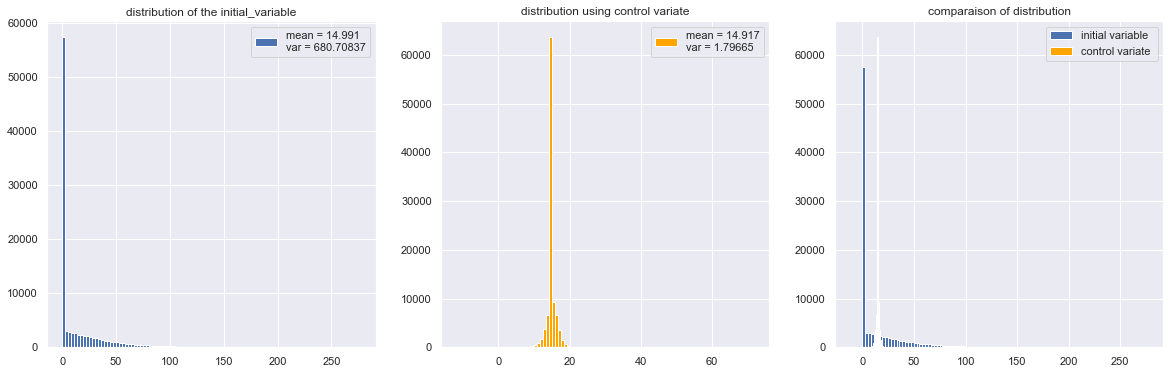

In [ ]:
plot_simulation(y, Y_control)

# Put  Worst_Of  Option

### 1. Data generation
we generate 500000 samples for our training and test set

In [ ]:
Z = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=nb_samples)
y = f_Put_Worst_Of(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_worst = DNN(N, other_layer = 2, neurone_by_layer = 64,metric="mae")

In [ ]:
nnmodel_worst.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 10)

Epoch 1/1000
12500/12500 [==============================] - 13s 1ms/step - loss: 29.9391 - mae: 4.0593 - val_loss: 24.4955 - val_mae: 3.8017
Epoch 2/1000
12500/12500 [==============================] - 11s 904us/step - loss: 24.3198 - mae: 3.7672 - val_loss: 24.6990 - val_mae: 3.8423
Epoch 3/1000
12500/12500 [==============================] - 12s 946us/step - loss: 23.9202 - mae: 3.7369 - val_loss: 23.8638 - val_mae: 3.7030
Epoch 4/1000
12500/12500 [==============================] - 11s 876us/step - loss: 23.6886 - mae: 3.7120 - val_loss: 23.5149 - val_mae: 3.6600
Epoch 5/1000
12500/12500 [==============================] - 12s 964us/step - loss: 23.5405 - mae: 3.7037 - val_loss: 23.0560 - val_mae: 3.6738
Epoch 6/1000
12500/12500 [==============================] - 12s 939us/step - loss: 23.4620 - mae: 3.6998 - val_loss: 23.4866 - val_mae: 3.6954
Epoch 7/1000
12500/12500 [==============================] - 14s 1ms/step - loss: 23.4340 - mae: 3.6928 - val_loss: 23.4767 - val_mae: 3.7104
Epo

### 3. Test  and evaluation of the model
We evaluate our model using Mean Absolute Error:  
    - first we generate a test set sample  
    - then we predict and evaluate the model

In [ ]:
Z = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
y = f_Put_Worst_Of(Z)
y_pred = nnmodel_worst.model.predict(Z)

3125/3125 [==============================] - 2s 565us/step


In [ ]:
mean_absolute_error(y, y_pred)

3.7541732621816197

### 4. Simulation

In [ ]:
y, Y_control = simulation(f_Put_Worst_Of,nnmodel_worst.model)

3125/3125 [==============================] - 2s 543us/step


#### **K = S0**

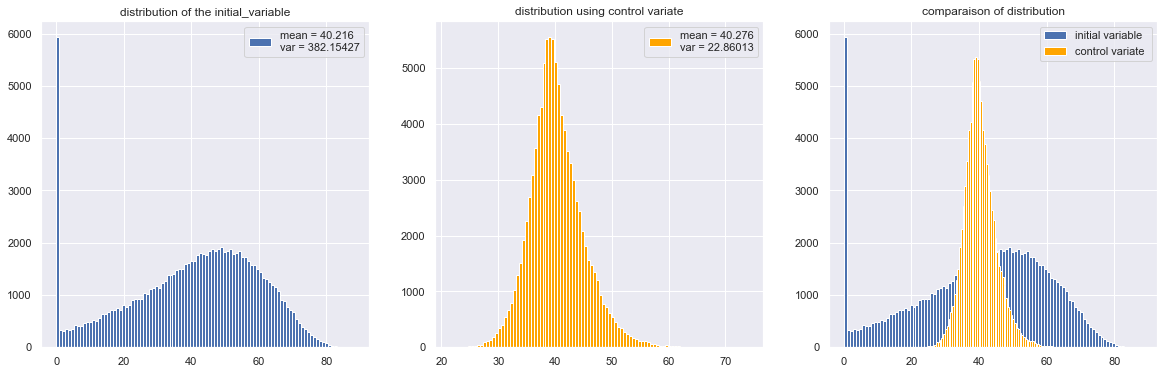

In [ ]:
plot_simulation(y, Y_control)

# Binary option (a digit) on the basket

### 1. Data generation

In [ ]:
Z = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
y = f_Digit_Basket(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

In [ ]:
nnmodel_binary = DNN(N, other_layer = 2, neurone_by_layer = 64,metric="mae")

In [ ]:
nnmodel_binary.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True)

Epoch 1/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 337.6685 - mae: 8.2019 - val_loss: 180.2886 - val_mae: 4.7060
Epoch 2/1000
2500/2500 [==============================] - 2s 942us/step - loss: 160.9319 - mae: 4.4364 - val_loss: 163.2469 - val_mae: 3.9559
Epoch 3/1000
2500/2500 [==============================] - 2s 943us/step - loss: 136.0079 - mae: 3.8476 - val_loss: 148.0358 - val_mae: 4.4690
Epoch 4/1000
2500/2500 [==============================] - 3s 1ms/step - loss: 123.7127 - mae: 3.6056 - val_loss: 117.8158 - val_mae: 3.6818
Epoch 5/1000
2500/2500 [==============================] - 2s 900us/step - loss: 113.5403 - mae: 3.3244 - val_loss: 129.1245 - val_mae: 2.8881
Epoch 6/1000
2500/2500 [==============================] - 2s 826us/step - loss: 108.5554 - mae: 3.2530 - val_loss: 113.2185 - val_mae: 3.0764
Epoch 7/1000
2500/2500 [==============================] - 2s 865us/step - loss: 103.7646 - mae: 3.1213 - val_loss: 89.4741 - val_mae: 2.4324
Epoch 8/100

### 3. Test  and evaluation of the model

In [ ]:
Z = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
y = f_Digit_Basket(Z)
y = y != 0
y_pred = nnmodel_binary.model.predict(Z)
y_pred = y_pred > G/2

3125/3125 [==============================] - 2s 571us/step


In [ ]:
accuracy_score(y, y_pred)

0.9912

### 4. Simulation

In [ ]:
W, model_cut = get_Weight_and_submodel(nnmodel_binary.model)
Z_simul = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
y = f_Digit_Basket(Z_simul)

Z_simul = multivariate_normal.rvs(cov = np.diag(np.ones(N)), size=M_simulation)
Z_tilde = multivariate_normal.rvs(cov = W@W.T, size=M_simulation)
    
HZ = nnmodel_binary.model.predict(Z_simul)
HZ_tilde = model_cut.predict(Z_tilde)
Y_control = f_Digit_Basket(Z_simul).reshape(HZ_tilde.shape) - G*(HZ>G/2)  + np.mean(HZ_tilde)


3125/3125 [==============================] - 2s 493us/step


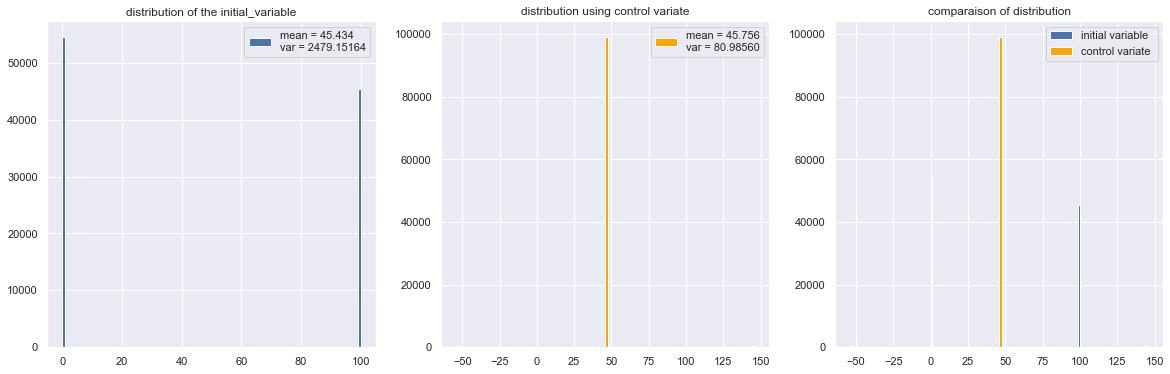

In [ ]:
plot_simulation(y, Y_control)

# Arithmetic asian option

### 1. Data generation

In [ ]:
Z = np.random.randn(nb_samples, N * Neuler)
y = f_Asian_Arithmetic(Z)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size=0.2)

### 2. Model Creation

In [ ]:
nnmodel_asian = DNN(N* Neuler)

In [ ]:
nnmodel_asian.fit(X_train, y_train, eval_set=(X_test,y_test), verbose = True, patience = 10)

Epoch 1/1000
1250/1250 [==============================] - 4s 2ms/step - loss: 31.6731 - mse: 31.6731 - val_loss: 9.7000 - val_mse: 9.7000
Epoch 2/1000
1250/1250 [==============================] - 3s 3ms/step - loss: 7.0365 - mse: 7.0365 - val_loss: 6.8081 - val_mse: 6.8081
Epoch 3/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 4.8674 - mse: 4.8674 - val_loss: 4.1562 - val_mse: 4.1562
Epoch 4/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 4.9829 - mse: 4.9829 - val_loss: 3.6622 - val_mse: 3.6622
Epoch 5/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 3.5587 - mse: 3.5587 - val_loss: 6.7252 - val_mse: 6.7252
Epoch 6/1000
1250/1250 [==============================] - 2s 2ms/step - loss: 4.2846 - mse: 4.2846 - val_loss: 3.6701 - val_mse: 3.6701
Epoch 7/1000
1250/1250 [==============================] - 4s 3ms/step - loss: 2.7164 - mse: 2.7164 - val_loss: 4.0615 - val_mse: 4.0615
Epoch 8/1000
1250/1250 [======================

### 3. Test  and evaluation of the model
We evaluate our model using Mean Absolute Error:  
    - first we generate a test set sample  
    - then we predict and evaluate the model

In [ ]:
Z = np.random.randn(M_simulation, N * Neuler)
y = f_Asian_Arithmetic(Z)
y_pred = nnmodel_asian.model.predict(Z)

313/313 [==============================] - 1s 3ms/step


In [ ]:
mean_squared_error(y, y_pred)

1.2517585418665262

### 4. Simulation

In [ ]:
y, Y_control = simulation(f_Asian_Arithmetic, nnmodel_asian.model, N = N * Neuler)

313/313 [==============================] - 1s 2ms/step


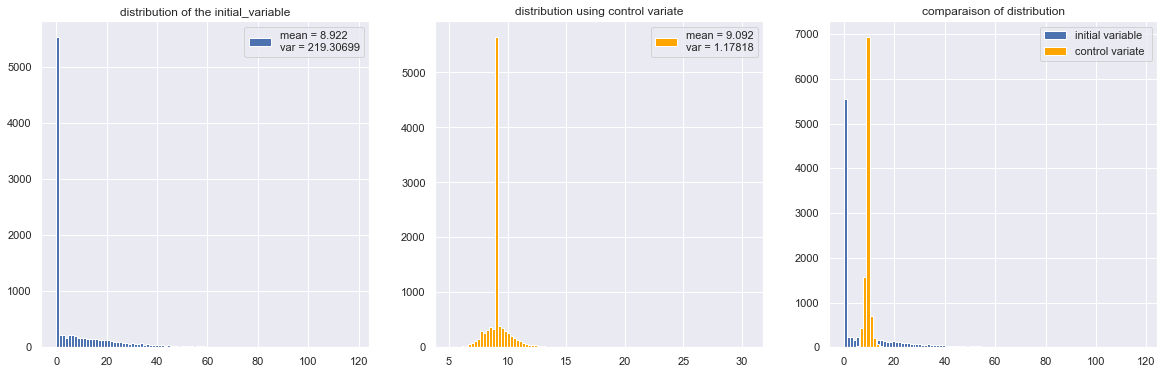

In [ ]:
plot_simulation(y, Y_control, [100, 100, 100, 20])